# Second attempt at implementing a Bayesian KDE  classifier

In [3]:


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactocentric, ICRS
from astropy.constants import kpc, au
from astropy.coordinates import CartesianRepresentation, CartesianDifferential
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
from numba import njit
import matplotlib.colors as colors

import random
import healpy as hp

from matplotlib.gridspec import GridSpec
from scipy.optimize import minimize


# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')


# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *
from scripts.CMD_selection import *

# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Load training data

In [4]:
# load catalogs
# save the catalogs
data_gaia_big= pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/CMD_training_catalogs/kappa_1.7_speedystar.csv') 
#pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/CMD_selection_testing_catalog/large_catalog_evolved.feather')

## Visualize the CMD of the training set

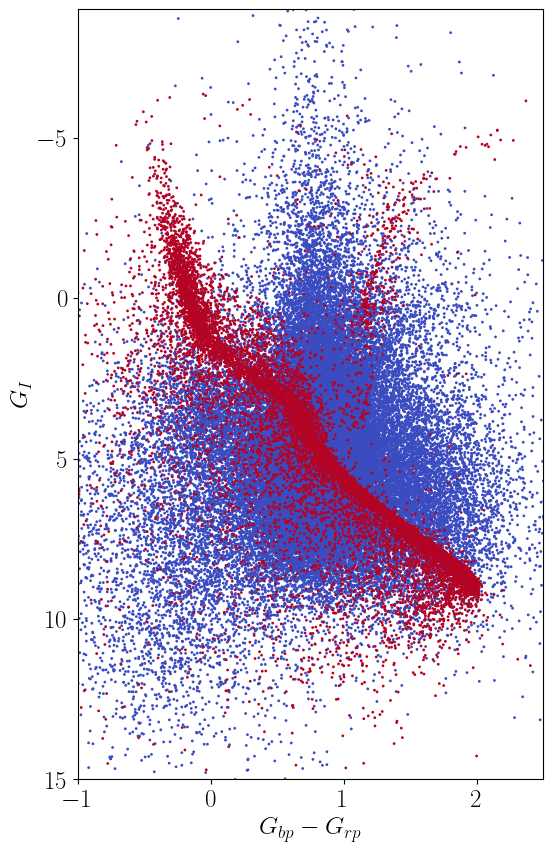

In [5]:
# plot CMD
fig, ax = plt.subplots(figsize = (6, 10))
ax.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=1, c=data_gaia_big['is_hvs'], cmap='coolwarm', vmin=0, vmax=1)
ax.set_xlim(-1, 2.5)
ax.set_ylim(15, -9)
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
plt.show()

In [6]:
# fit a 2D KDE to the CMD
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


class BayesianKDEClassifier:

    def __init__(self, X, Y, C, threshold=0.5, bandwidth=1.0):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.C = np.array(C)
        self.threshold = threshold
        self.base_bandwidth = bandwidth

        # Split data by class
        X_class = self.X[self.C]
        Y_class = self.Y[self.C]
        X_not_class = self.X[~self.C]
        Y_not_class = self.Y[~self.C]

        # Calculate prior probabilities
        self.p_class = np.mean(self.C)
        self.p_not_class = 1 - self.p_class

        # Fit 2D KDEs for each class with base bandwidth
        XY_class = np.vstack([X_class, Y_class]).T
        XY_not_class = np.vstack([X_not_class, Y_not_class]).T

        self.kde_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(XY_class)
        self.kde_not_class = KernelDensity(kernel='gaussian', bandwidth=self.base_bandwidth).fit(XY_not_class)
    
    def classify(self, x, y, x_err=0, y_err=0):
        """
        Classify points based on the KDE-based Bayesian model with analytical error integration.

        Parameters:
        - x (array-like): Input data for feature X.
        - y (array-like): Input data for feature Y.
        - x_err (float or array-like): Standard deviation of errors in X.
        - y_err (float or array-like): Standard deviation of errors in Y.

        Returns:
        - classification (bool array): True if classified as part of the class, False otherwise.
        - p_class_given_data (array): Probability of being in the class.
        - p_not_class_given_data (array): Probability of not being in the class.
        - p_data (array): Total probability of the data.
        """
        # Adjust the bandwidth based on measurement error (assuming isotropic errors)
        effective_bandwidth = np.sqrt(self.base_bandwidth**2 + x_err**2 + y_err**2)
        
        # Create temporary KDEs with adjusted bandwidths for each case
        kde_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth)
        kde_class.fit(np.vstack([self.X[self.C], self.Y[self.C]]).T)
        
        kde_not_class = KernelDensity(kernel='gaussian', bandwidth=effective_bandwidth)
        kde_not_class.fit(np.vstack([self.X[~self.C], self.Y[~self.C]]).T)
        
        # Prepare input data
        data = np.vstack([x, y]).T
        
        # Calculate log-likelihoods with adjusted KDEs
        log_p_data_given_class = kde_class.score_samples(data)
        log_p_data_given_not_class = kde_not_class.score_samples(data)
        
        # Convert log-likelihoods to likelihoods
        p_data_given_class = np.exp(log_p_data_given_class)
        p_data_given_not_class = np.exp(log_p_data_given_not_class)
        
        # Total probability of data
        p_data = p_data_given_class * self.p_class + p_data_given_not_class * self.p_not_class
        
        # Posterior probabilities P(class|data) and P(not class|data)
        p_class_given_data = (p_data_given_class * self.p_class) / p_data
        p_not_class_given_data = (p_data_given_not_class * self.p_not_class) / p_data
        
        # Classification based on threshold
        classification = p_class_given_data >= self.threshold
        
        return classification, p_class_given_data, p_not_class_given_data, p_data
    

    def debug_kde_fit(self, x_range=(-1, 2.5), y_range=(15, -7), resolution=100):
        """
        Debug KDE by plotting it alongside the original data to compare fit.

        Parameters:
        - x_range (tuple): Range of x values for the plot (default is (-1, 2.5)).
        - y_range (tuple): Range of y values for the plot (default is (15, -7)).
        - resolution (int): Number of points along each axis (default is 100).
        """

        # calculate log-likelihoods with the KDEs for a range of data points to plot contours
        X_range = np.linspace(x_range[0], x_range[1], resolution)
        Y_range = np.linspace(y_range[0], y_range[1], resolution)
        X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
        XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

        log_p_data_given_hvs = self.kde_class.score_samples(XY_mesh)
        log_p_data_given_not_hvs = self.kde_not_class.score_samples(XY_mesh)

        # plot the KDE and the original data for each class
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        # Plot the "class" data
        ax[0].scatter(self.X[self.C], self.Y[self.C], s=1, c='blue', alpha=0.5)
        cbar_1 = ax[0].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(resolution, resolution),
                                 cmap='Blues', levels = 20, alpha = 0.6)
        ax[0].set_title('HVS KDE')
        ax[0].set_xlim(x_range)
        ax[0].set_ylim(y_range)
        ax[0].set_xlabel("$G_{bp} - G_{rp}$")
        ax[0].set_ylabel("$G_{I}$")

        # Plot the "not class" data
        ax[1].scatter(self.X[~self.C], self.Y[~self.C], s=1, c='red', alpha=0.5)
        cbar_2 = ax[1].contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_not_hvs).reshape(resolution, resolution),
                                 cmap='Reds', levels = 30, alpha = 0.6)
        ax[1].set_title('Non-HVS KDE')
        ax[1].set_xlim(x_range)
        ax[1].set_ylim(y_range)
        ax[1].set_xlabel("$G_{bp} - G_{rp}$")
        ax[1].set_ylabel("$G_{I}$")

        # add colorbars
        fig.colorbar(cbar_1, ax=ax[0], label = '$P(data|hvs)$')
        fig.colorbar(cbar_2, ax=ax[1], label = '$P(data|non-hvs)$')

        plt.tight_layout()
        plt.show()


        

Text(0, 0.5, '$G_{I}$')

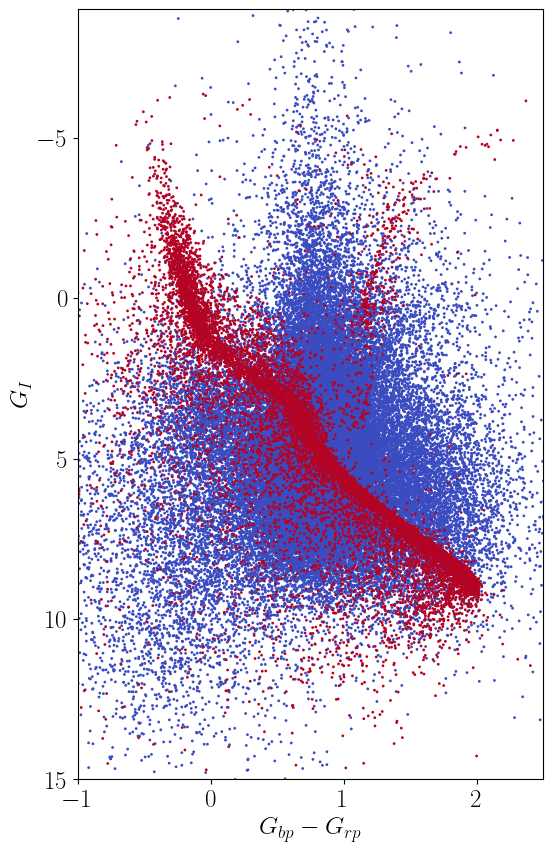

In [7]:
X = data_gaia_big['bp_rp_corr'].values
Y = data_gaia_big['implied_M_g_corr'].values
C = np.bool(data_gaia_big['is_hvs'])
bayesian_kde = BayesianKDEClassifier(X, Y, C, bandwidth=0.1)

# Plot the KDEs
fig, ax = plt.subplots(figsize = (6, 10))
ax.scatter(data_gaia_big['bp_rp_corr'], data_gaia_big['implied_M_g_corr'], s=1, c=data_gaia_big['is_hvs'], cmap='coolwarm', vmin=0, vmax=1)
ax.set_xlim(-1, 2.5)
ax.set_ylim(15, -9)
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')


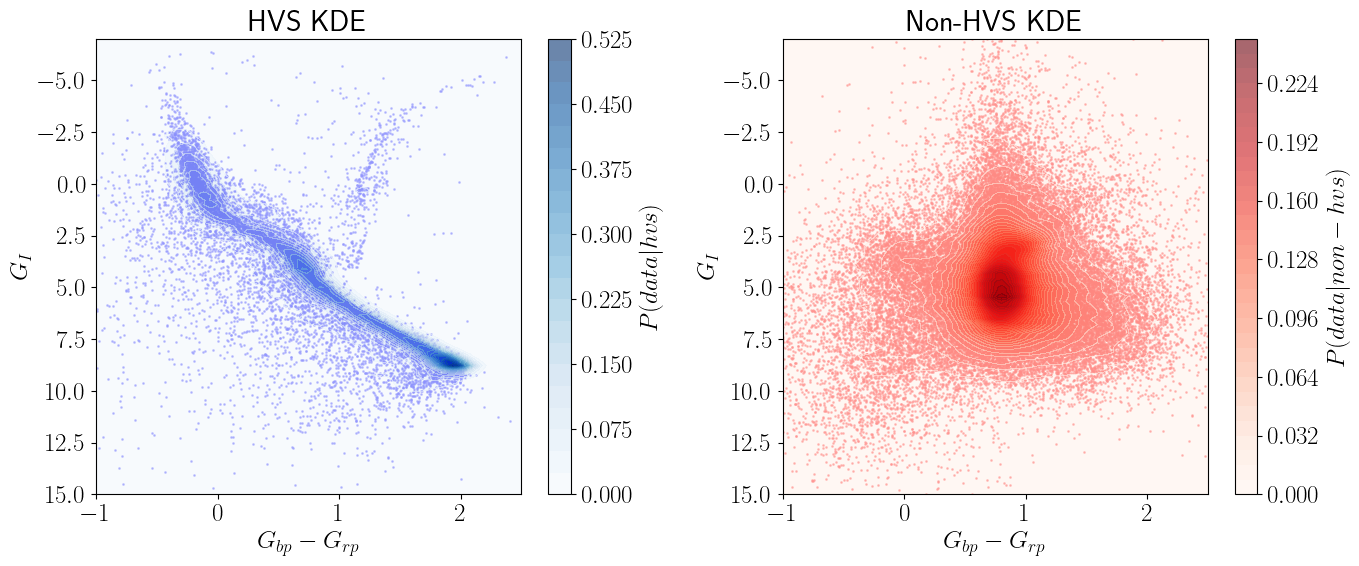

In [8]:
bayesian_kde.debug_kde_fit()

In [9]:
# calculate log-likelihoods with the KDEs for a range of data points to plot contours
X_range = np.linspace(-1, 2.5, 100)
Y_range = np.linspace(-9, 15, 100)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

log_p_data_given_hvs = bayesian_kde.kde_class.score_samples(XY_mesh)



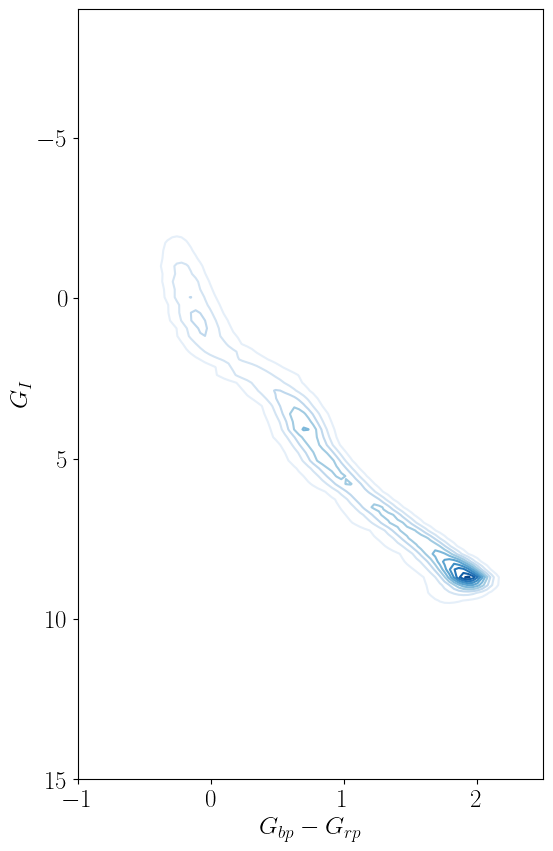

In [10]:
# Reshape the log-likelihoods to a 2D grid
log_p_data_given_hvs = log_p_data_given_hvs.reshape(X_mesh.shape)

# Plot the contours
plt.figure(figsize=(6, 10))
plt.contour(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs), levels=10, cmap='Blues')
plt.ylim(15, -9)
plt.xlabel('$G_{bp} - G_{rp}$')
plt.ylabel('$G_{I}$')
plt.show()

In [14]:
# Generate the grid
x_i = np.linspace(-1, 2.5, 300)
y_i = np.linspace(15, -7, 300)
X, Y = np.meshgrid(x_i, y_i)

# Flatten X and Y to a 1D array of points
X_flat = X.ravel()
Y_flat = Y.ravel()

# Calculate probabilities for all points at once
classification, hvs_prob_flat, background_prob_flat, total_prob_flat = bayesian_kde.classify(X_flat, Y_flat)

# Reshape the results back to the grid shape
hvs_prob = hvs_prob_flat.reshape(X.shape)
background_prob = background_prob_flat.reshape(X.shape)
total_probability = total_prob_flat.reshape(X.shape)


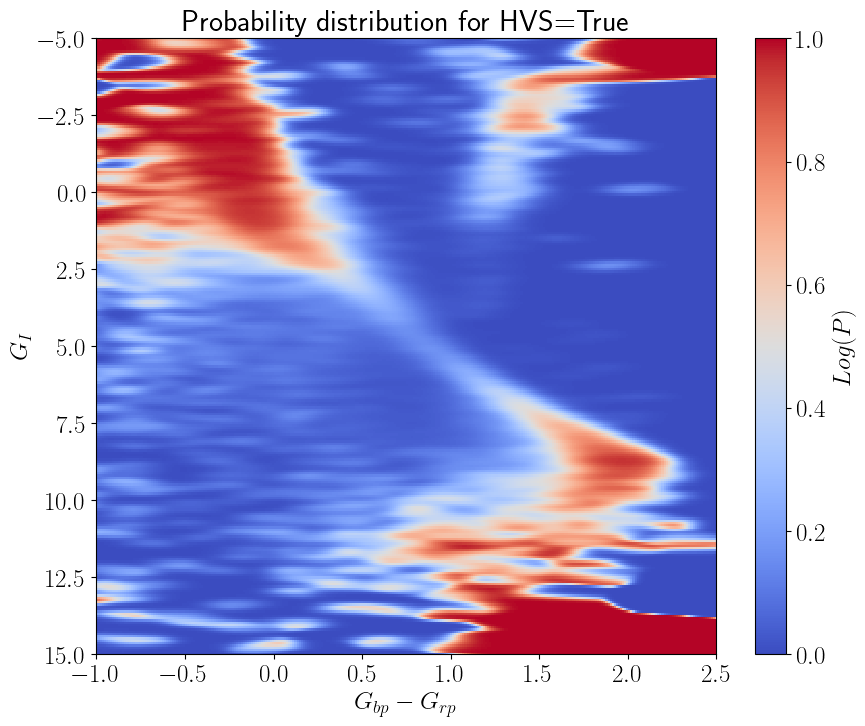

In [15]:
# Plot the 2D probability distribution
fig, ax = plt.subplots(figsize=(10, 8))
c = ax.pcolormesh(X, Y, hvs_prob, cmap='coolwarm', shading= 'auto')# norm=colors.LogNorm(vmin=hvs_prob.min()+1e-11, vmax=hvs_prob.max()) ) #
ax.set_xlabel('$G_{bp} - G_{rp}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(-1, 2.5)
ax.set_ylim(15, -5)
#ax.invert_yaxis()
ax.set_title('Probability distribution for HVS=True')
fig.colorbar(c, label='$Log(P)$')
plt.show()